In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import datetime

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.markers import MarkerStyle

## Apple Mobility Data
***

#### Functions:

In [2]:
def save_AMD_Italy():
    '''
    Generates the reduced CSV to speed up the loading time
    '''
    df = pd.read_csv("DATA/AMD/applemobilitytrends-2022-02-10.csv")
    df_out = applyfilter(df, {"country"  : ["Italy"], 
                              "geo_type" : ["sub-region"]})
    df_out.drop(["geo_type", "alternative_name", "sub-region", "country"], 1, inplace=True)
    #driving_norm, walking_norm = 0, 0
    # The following try except are implemented due to the fact that some regions lack the walking data
    #for region in region_name:
    #    
    #    try:
    #        walking_values += applyfilter(df_out, {"region" : [region], "transportation_type" : ["walking"]}).iloc[:,2:].values.flatten() * weight_dict[region]
    #    except Exception:
    #        pass
    #    else:
    #        walking_norm += weight_dict[region]
    #print(driving_norm,walking_norm)
    #df_tmp = pd.DataFrame([["Italy", "driving", *driving_values/driving_norm],
    #                       ["Italy", "walking", *walking_values/walking_norm]], columns=df_out.columns)
    #df_out = pd.concat([df_out, df_tmp], ignore_index=True)
    df_out.to_csv("DATA/AMD/applemobilitytrends_ITA-2022-02-10.csv", index=False)

def load_AMD_Italy():
    '''
    Load the AMD referred to Italy and return the dataframe and the dates, 
    and eventually saves the list of all possible cities/regions
    '''
    df = pd.read_csv("DATA/AMD/applemobilitytrends_ITA-2022-02-10.csv")
    dates_str  = df.columns[2:] # list of sting
    return df, dates_str

def applyfilter(df, dictionary):
    '''
    Filter the dataframe according to the dictionary: the values needs to be a list
    The order matters
    '''
    df_out = df.copy()
    for key in dictionary.keys():
        sub_df = [df_out.loc[df_out[key] == val] for val in dictionary[key]]
        df_out = pd.concat(sub_df, ignore_index=True)

    return df_out

def fill_missing(df):
    '''
    AMD driving are missing for the 2020-05-11, 2020-05-12 
    AMD are missing for the 2021-03-12
    '''
    df_driv = df.loc[df["transportation_type"] == "driving", ["2020-05-10","2020-05-13"]]
    values = (df_driv["2020-05-10"].values + df_driv["2020-05-13"].values)/2
    df.loc[df["transportation_type"] == "driving", "2020-05-11"] = values
    df.loc[df["transportation_type"] == "driving", "2020-05-12"] = values
    df["2021-03-12"] = (df["2021-03-11"] + df["2021-03-13"])/2

def transform_week_RAVG(dataframe, cols, window=7):
    '''
    Substitute the mobility data with it's rolling average
    '''
    values = dataframe[cols].values
    RAVG = np.array([values[:,ii-window:ii].sum(axis=1)/window for ii in np.arange(window,len(cols)+1)]).T
    dataframe[cols[:window-1]] = np.NaN
    dataframe[cols[window-1:]] = RAVG
    
def from_to(date_list, start, end):
    '''
    Return the indexes of a date list corresponding to the period between start and end
    '''
    a = list(date_list).index(start)
    b = list(date_list).index(end)
    return slice(a,b+1), np.arange(a,b+1)   # we need np because integer operation are not allowed on range object

#### Examples:

In [3]:
# Obviously needs to be run just the first time to generate the CVS
#save_AMD_Italy()
df_amd, dates_str_amd = load_AMD_Italy()
fill_missing(df_amd)
transform_week_RAVG(df_amd, dates_str_amd)
region_list_amd = np.unique(df_amd["region"].values)
dates_datetime_amd = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates_str_amd]
df_amd.head()

,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,...,2022-02-01,2022-02-02,2022-02-03,2022-02-04,2022-02-05,2022-02-06,2022-02-07,2022-02-08,2022-02-09,2022-02-10
0,Abruzzo Region,driving,NaN,NaN,NaN,NaN,NaN,NaN,106.295714,106.267143,...,138.440000,137.808571,137.991429,137.358571,136.084286,133.504286,134.070000,134.352857,135.762857,136.315714
1,Abruzzo Region,walking,NaN,NaN,NaN,NaN,NaN,NaN,111.790000,113.278571,...,175.931429,176.121429,174.678571,172.627143,168.042857,164.775714,163.804286,164.785714,165.158571,167.681429
2,Apulia Region,driving,NaN,NaN,NaN,NaN,NaN,NaN,106.478571,106.725714,...,129.600000,129.788571,130.055714,130.615714,131.090000,131.641429,132.187143,133.182857,134.434286,136.601429
3,Apulia Region,walking,NaN,NaN,NaN,NaN,NaN,NaN,110.544286,110.660000,...,150.231429,151.904286,152.297143,152.602857,154.515714,155.550000,155.257143,156.937143,158.192857,161.128571
4,Autonomous Region Aosta Valley,driving,NaN,NaN,NaN,NaN,NaN,NaN,138.260000,138.518571,...,184.881429,184.214286,185.864286,186.568571,183.064286,179.954286,180.338571,182.091429,183.322857,183.782857


Plot of the mobility data for all regions 

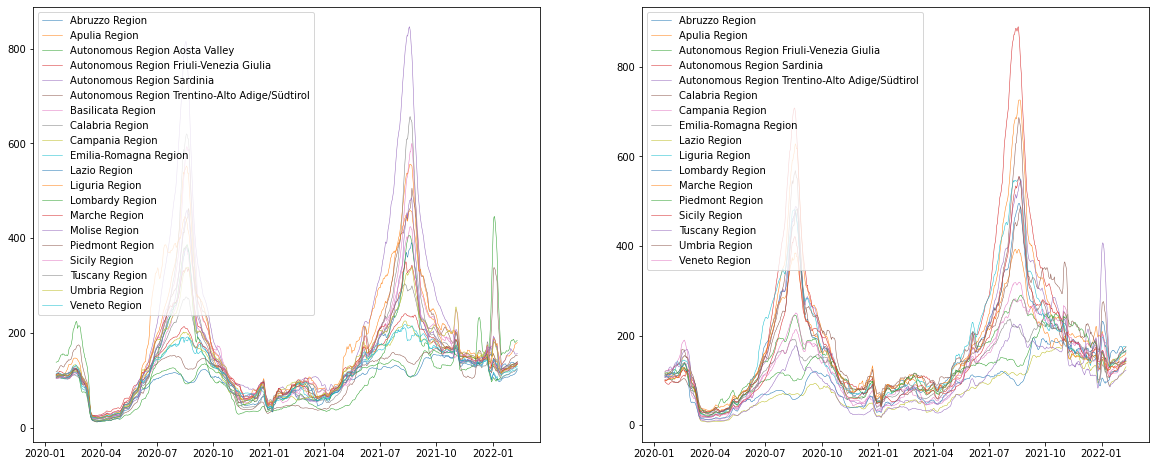

In [4]:
fig, ax = plt.subplots(1,2, figsize=[20,8])
for region in region_list_amd:
    try:
        ax[0].plot(dates_datetime_amd, applyfilter(df_amd, {"region" : [region]}).iloc[0,2:], label=region, linewidth=0.5)
    except Exception:
        pass
    
    try:
        ax[1].plot(dates_datetime_amd, applyfilter(df_amd, {"region" : [region]}).iloc[1,2:], label=region, linewidth=0.5)
    except Exception:
        pass
ax[0].legend()
ax[1].legend()
plt.show()

## Google Mobility Data
***

#### Functions:

In [5]:
def save_GMD():
    '''
    '''
    df_out = pd.DataFrame()
    for year in ['2020', '2021', '2022']:
        df = pd.read_csv("DATA/GMD/"+year+"_IT_Region_Mobility_Report.csv")
        mask_1 = np.logical_not(df['sub_region_1'].isnull())
        mask_2 = df['sub_region_2'].isnull()
        df.drop(labels = ["country_region_code", "country_region", "sub_region_2", 'metro_area','iso_3166_2_code',
                 'census_fips_code', 'place_id'], axis=1, inplace=True)
        df_out = pd.concat([df_out, df[mask_1 & mask_2]], ignore_index=True)
    df_out.to_csv('DATA/GMD/GMD_final.csv', index=False)

def load_GMD():
    '''
    '''
    df = pd.read_csv("DATA/GMD/GMD_final.csv")
    df['residential_percent_change_from_baseline'] = 100-df['residential_percent_change_from_baseline']
    dates_str = np.unique(df["date"])
    return df, dates_str

#### Examples:

In [6]:
save_GMD()
df_gmd, dates_str_gmd = load_GMD()
region_list_gmd = np.unique(df_gmd["sub_region_1"].values)
dates_datetime_gmd = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates_str_gmd]
for region in region_list_gmd:
    df_gmd.loc[df_gmd['sub_region_1'] == region,'residential_percent_change_from_baseline'] = df_gmd.loc[df_gmd['sub_region_1'] == region,'residential_percent_change_from_baseline'].rolling(7).mean()
df_gmd.head(10)

,sub_region_1,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Abruzzo,2020-02-15,2.0,2.0,36.0,9.0,0.0,NaN
1,Abruzzo,2020-02-16,2.0,8.0,47.0,26.0,-1.0,NaN
2,Abruzzo,2020-02-17,-1.0,2.0,11.0,7.0,1.0,NaN
3,Abruzzo,2020-02-18,1.0,2.0,22.0,5.0,2.0,NaN
4,Abruzzo,2020-02-19,-4.0,-1.0,-12.0,1.0,1.0,NaN
5,Abruzzo,2020-02-20,1.0,4.0,-3.0,5.0,1.0,NaN
6,Abruzzo,2020-02-21,1.0,3.0,6.0,7.0,0.0,100.857143
7,Abruzzo,2020-02-22,1.0,6.0,34.0,8.0,0.0,100.714286
8,Abruzzo,2020-02-23,2.0,17.0,54.0,20.0,3.0,100.714286
9,Abruzzo,2020-02-24,5.0,19.0,25.0,2.0,-10.0,100.428571


## Protezione civile
***

#### Functions:

In [7]:
def save_prot_civ():
    df = pd.read_csv("DATA/prot_civ/itaregioni.csv")
    #df = df[['data', 'denominazione_regione', 'nuovi_positivi', 'totale_casi']]
    df = df[['data', 'denominazione_regione', 'nuovi_positivi', 'totale_casi', 'ricoverati_con_sintomi', 'ingressi_terapia_intensiva', 'tamponi']]
    df_trentino = df[(df['denominazione_regione'] == 'P.A. Bolzano') | (df['denominazione_regione'] == 'P.A. Trento')].groupby('data', as_index = False).sum()
    df_trentino['denominazione_regione'] = 'Trentino alto adige' 
    df_prot_civ = pd.concat([df, df_trentino], ignore_index=True)
    df_prot_civ = df_prot_civ[(df_prot_civ['denominazione_regione'] != 'P.A. Bolzano') & (df_prot_civ['denominazione_regione'] != 'P.A. Trento')]
    #df_prot_civ = df ## remove to backup
    df_prot_civ['data'] = [date.split('T')[0] for date in df_prot_civ['data']]
    df_prot_civ.to_csv("DATA/prot_civ/itaregioni_final.csv", index=False)

def load_prot_civ():
    '''
    '''
    df = pd.read_csv("DATA/prot_civ/itaregioni_final.csv")
    dates_str = np.unique(df["data"])
    return df, dates_str

#### Examples:

In [8]:
# To run just the first time
save_prot_civ()
df_pc, dates_str_pc = load_prot_civ()
region_list_pc = np.unique(df_pc["denominazione_regione"].values)
dates_datetime_pc = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates_str_pc]
df_pc.head()
#dates_datetime_pc

,data,denominazione_regione,nuovi_positivi,totale_casi,ricoverati_con_sintomi,ingressi_terapia_intensiva,tamponi
0,2020-02-24,Abruzzo,0,0,0,NaN,5
1,2020-02-24,Basilicata,0,0,0,NaN,0
2,2020-02-24,Calabria,0,0,0,NaN,1
3,2020-02-24,Campania,0,0,0,NaN,10
4,2020-02-24,Emilia-Romagna,18,18,10,NaN,148


The following dictionary assigns to each region name in the pc dataset the correspondant of the amd one since they are named differently. In order to keep both ways for naming regions `region_dict` is created

In [9]:
region_sorted_pc = ["Abruzzo", "Puglia", "Valle d'Aosta", "Friuli Venezia Giulia",
                    "Sardegna", "Trentino alto adige", "Basilicata", "Calabria", 
                    "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Lombardia", 
                    "Marche", "Molise", "Piemonte", "Sicilia", "Toscana", "Umbria", "Veneto"]

region_dict = dict(sorted({key : value for key,value in zip(region_sorted_pc, region_list_amd)}.items()))

In [10]:
region_dict_GMD = {'Abruzzo': 'Abruzzo',
                   'Basilicata': 'Basilicata',
                   'Calabria': 'Calabria',
                   'Campania': 'Campania',
                   'Emilia-Romagna': 'Emilia-Romagna',
                   'Friuli Venezia Giulia': 'Friuli-Venezia Giulia',
                   'Lazio': 'Lazio',
                   'Liguria': 'Liguria',
                   'Lombardia': 'Lombardy',
                   'Marche': 'Marche',
                   'Molise': 'Molise',
                   'Piemonte': 'Piedmont',
                   'Puglia': 'Apulia',
                   'Sardegna': 'Sardinia',
                   'Sicilia': 'Sicily',
                   'Toscana': 'Tuscany',
                   #'Trentino alto adige': 'Autonomous Region Trentino-Alto Adige/Südtirol',
                   'Umbria': 'Umbria',
                   "Valle d'Aosta": 'Aosta',
                   'Veneto': 'Veneto'}

## Colors
***

In [11]:
def generate_tseries(df):
    '''
    The input of the function is the dataframe containing colors information on regions, it is composed of rows 
    corresponding to a date time with columns telling about the region name and the color of the region at that 
    date time
    '''
    start_date = df.iloc[0,0]
    out = {'bianco'    : [],
           'giallo'    : [],
           'arancione' : [],
           'rosso'     : []}
    
    for row in range(1,len(df)-1):
        curr_date  = df.iloc[row,0]
        curr_color = df.iloc[row,2]
        # if new color
        if (curr_color != df.iloc[row-1,2]):
            start_date = curr_date
        # if last color
        if (curr_color != df.iloc[row+1,2]):
            out[curr_color].append((start_date, curr_date))
    out[df.iloc[row,2]].append((start_date, df.iloc[row,0]))
    return out

In [12]:
colors = pd.read_csv('DATA/dataset_colori.csv')
prova = generate_tseries(applyfilter(colors, {'denominazione_regione' : ['Abruzzo']}))
# datetime.datetime.strptime(prova['giallo'][0][0], "%Y-%m-%d").date()
# dates_str_amd
prova

{'bianco': [('2021-06-07', '2022-01-09')],
 'giallo': [('2020-11-06', '2020-11-09'),
  ('2021-01-07', '2021-01-08'),
  ('2021-01-11', '2021-01-16'),
  ('2021-02-01', '2021-02-13'),
  ('2021-04-26', '2021-06-06'),
  ('2022-01-10', '2022-01-23')],
 'arancione': [('2020-11-10', '2020-11-21'),
  ('2020-12-13', '2020-12-23'),
  ('2020-12-28', '2020-12-30'),
  ('2021-01-04', '2021-01-04'),
  ('2021-01-09', '2021-01-10'),
  ('2021-01-17', '2021-01-31'),
  ('2021-02-14', '2021-04-02'),
  ('2021-04-06', '2021-04-25'),
  ('2022-01-24', '2022-02-15')],
 'rosso': [('2020-11-22', '2020-12-12'),
  ('2020-12-24', '2020-12-27'),
  ('2020-12-31', '2021-01-03'),
  ('2021-01-05', '2021-01-06'),
  ('2021-04-03', '2021-04-05')]}

In [13]:
list_of_colors = [(name,group) for name,group in colors.groupby('denominazione_regione')]
list_of_colors[0][1]
# this list contains colors information for all regions in order, the first index selcts the region while the second 
# if zero tells us about the name of the region, if one represents the actual dataframe of the region's colors 

,data,denominazione_regione,colore
0,2020-11-06,Abruzzo,giallo
1,2020-11-07,Abruzzo,giallo
2,2020-11-08,Abruzzo,giallo
3,2020-11-09,Abruzzo,giallo
4,2020-11-10,Abruzzo,arancione
...,...,...,...
463,2022-02-12,Abruzzo,arancione
464,2022-02-13,Abruzzo,arancione
465,2022-02-14,Abruzzo,arancione
466,2022-02-15,Abruzzo,arancione


What are we going to do from now on?
#### "Generation time" lag analysis
- Use colors for single regions and analyse wrt epidemic waves the correlation between mobility and incidence in order to find lags. Separate in waves and in each wave see for each regions what colors sub windows of time can tell us. Remember to neglect summer time windows since restrictions were much lower than the actual colors ones;
- After a rough estimation of lag, we can differentiate lag for waves we may interpret whether results are compatible with the story of  the infection, incubation period and reporting of cases;

## Correlation test
***

#### Functions

In order to compare colors restrictions efficacy we may adopt this strategy:

we first notice that for the single region of Abruzzo colors changes are directly reflected, without lag, into a change of mobility as it's possible to see from the following plot. For this reason we want to discover whether in the other regions the behavior is the same or not. If it were the same then we could possibly compute the change in magnitude of mobility when entering into a new color region with respect to time evolution of the epidemic. 

For those regions where this behavior is not present it would be nice to compute the day after the issuing of restrictions when they are actually respected. 

In [14]:
actual_regions = list(region_dict.keys())
actual_regions.remove('Trentino alto adige')

In [15]:
df_gmd

,sub_region_1,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Abruzzo,2020-02-15,2.0,2.0,36.0,9.0,0.0,NaN
1,Abruzzo,2020-02-16,2.0,8.0,47.0,26.0,-1.0,NaN
2,Abruzzo,2020-02-17,-1.0,2.0,11.0,7.0,1.0,NaN
3,Abruzzo,2020-02-18,1.0,2.0,22.0,5.0,2.0,NaN
4,Abruzzo,2020-02-19,-4.0,-1.0,-12.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...
14755,Veneto,2022-02-17,-10.0,9.0,9.0,-26.0,-8.0,96.142857
14756,Veneto,2022-02-18,-11.0,9.0,16.0,-22.0,-7.0,96.285714
14757,Veneto,2022-02-19,-13.0,4.0,10.0,-21.0,-5.0,96.142857
14758,Veneto,2022-02-20,-13.0,-10.0,56.0,2.0,-1.0,96.142857


In [16]:
from plotly.subplots import make_subplots

for region in actual_regions:

    df_mob = applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD[region]]}).iloc[:, 7]
    df_col = applyfilter(colors, {'denominazione_regione' : [region]})
    # we are not interested in incidence here since we want to see the relation between mobility and colors

    translate = {'bianco'    : 'white',
                'giallo'    : 'yellow',
                'arancione' : 'orange',
                'rosso'     : 'red'}

    color_list = [translate[col] for col in df_col.colore.values] # it's the time sequence without dates of colors
    start_date = df_col.iloc[0,0] # it's the start day of restrictions in Abruzzo, the six of november the same for each region
    end_date   = df_col.iloc[-1,0] # the end of the dataframe is set to the 10th of february 2022
    slice_mob, mask_mob = from_to(dates_str_gmd, start_date, end_date) # slice mob is  just the slice in the time window that 
    # indicates the start and stop point of the time series. mask mob is the np.arange(slice_mob.start,slice_mob.stop) useful
    # for selecting those elements falling into the slice mob range 
    slice_col, mask_col = from_to(df_col.data.values, start_date, end_date)

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Bar(x=dates_datetime_gmd[slice_mob][1:], y = (df_mob.iloc[mask_mob[1:]]).values - (df_mob.iloc[mask_mob[:-1]]).values,
                marker_color=color_list[slice_col][1:]), secondary_y=False)
    fig.update_layout(title = ('Mobility differences in {}'.format(region_dict[region])))
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_yaxes(fixedrange=False)
    fig.show()

let's see how to implement the change in color restriction lag behavior control for one region. The change we expect is instantaneus from when restrictions are issued to when they are actually applied.

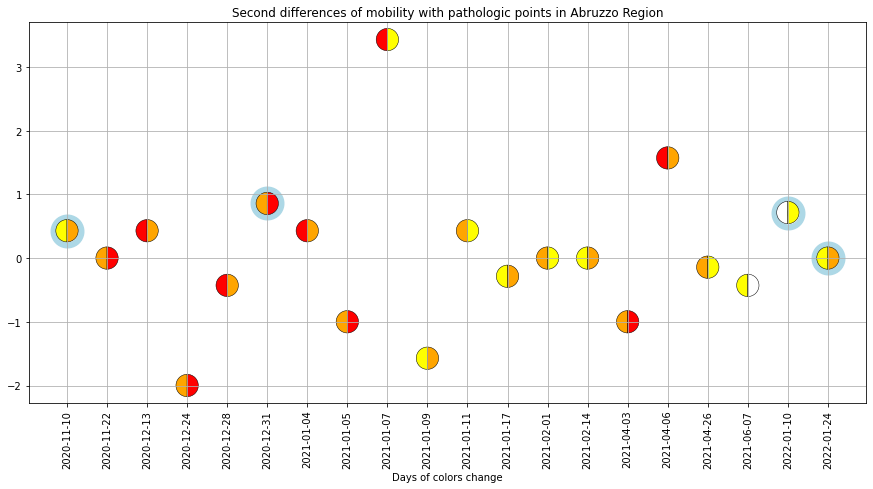

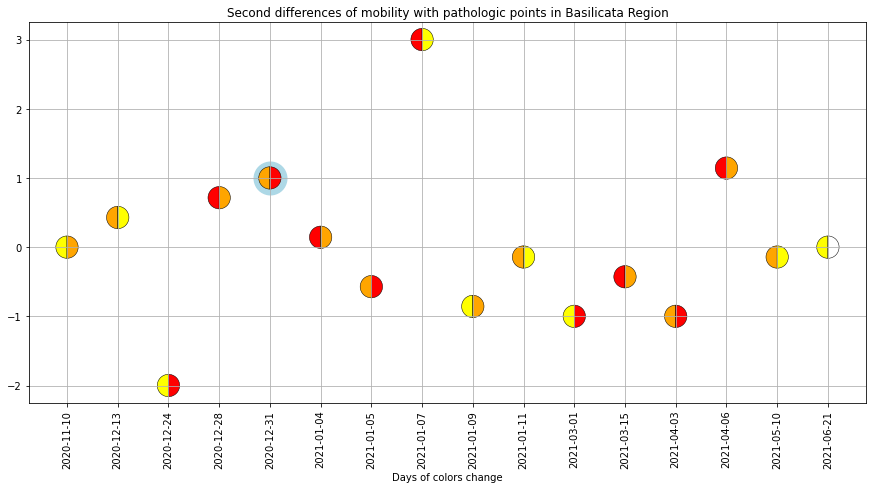

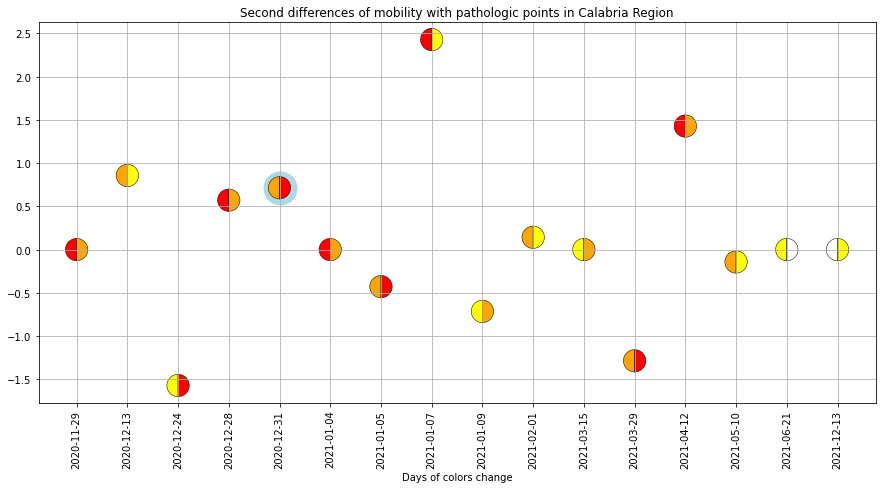

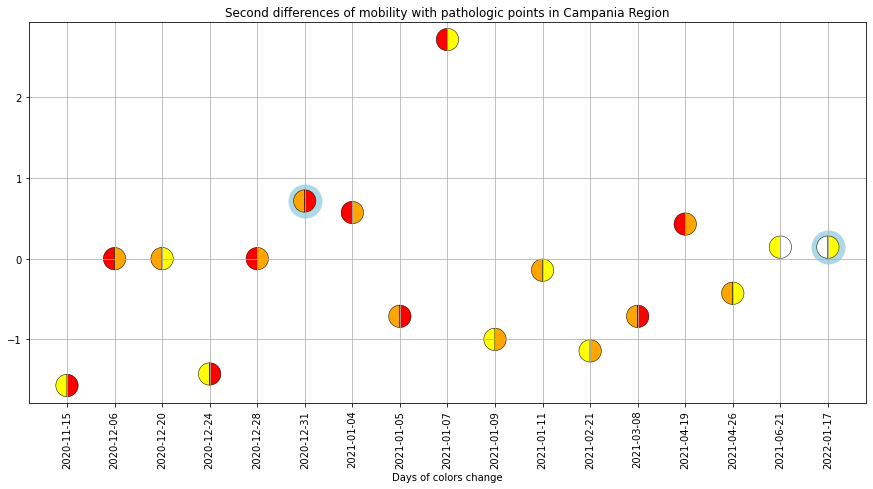

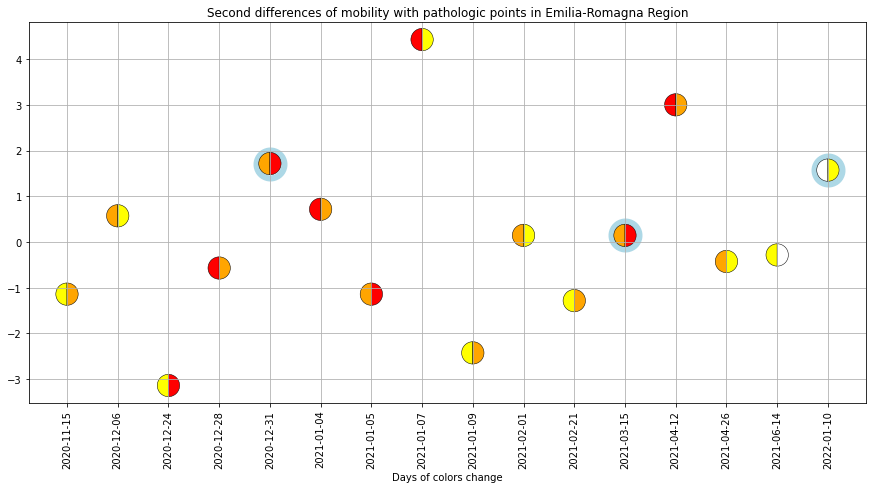

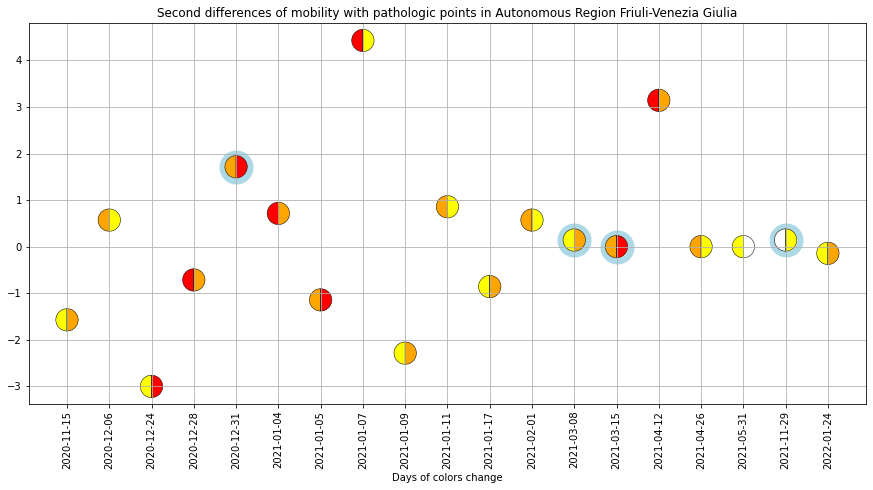

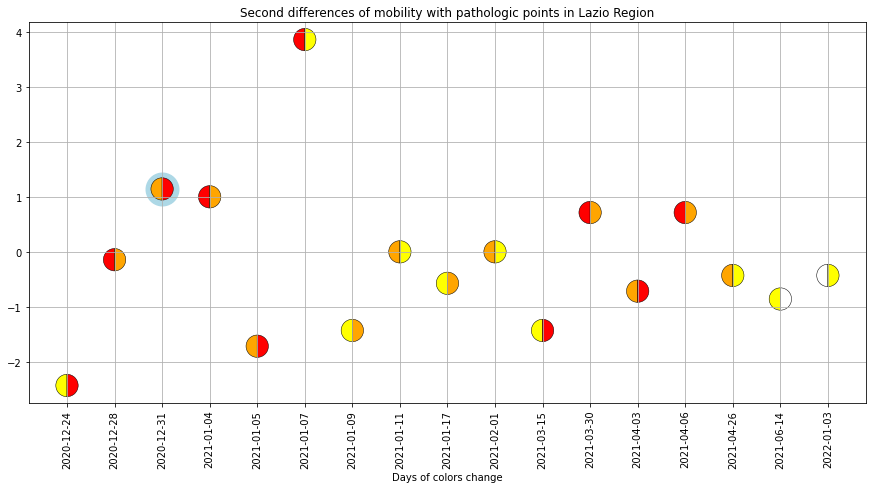

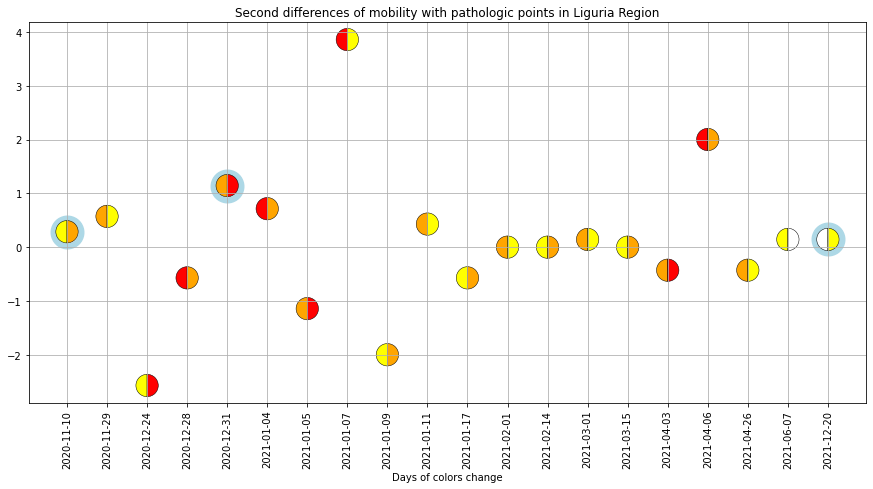

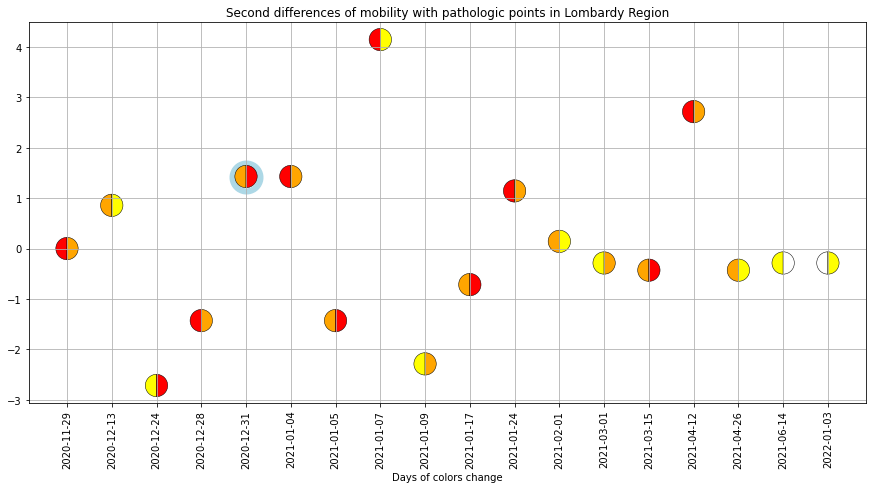

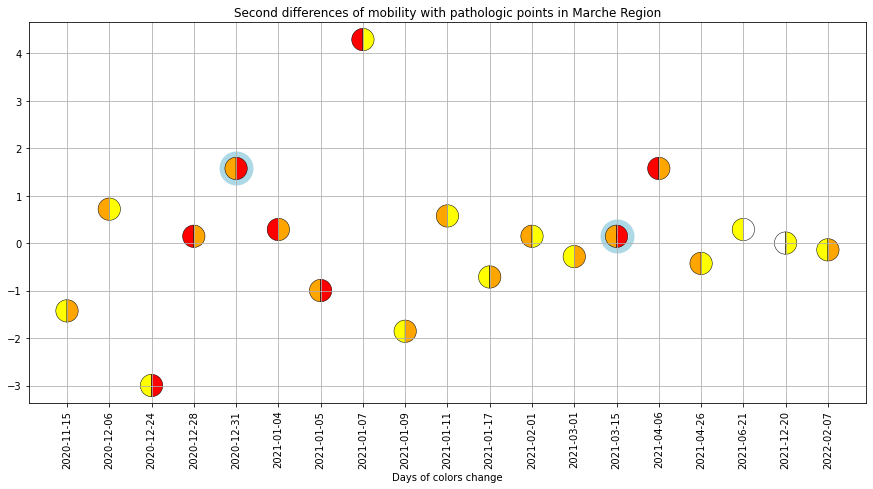

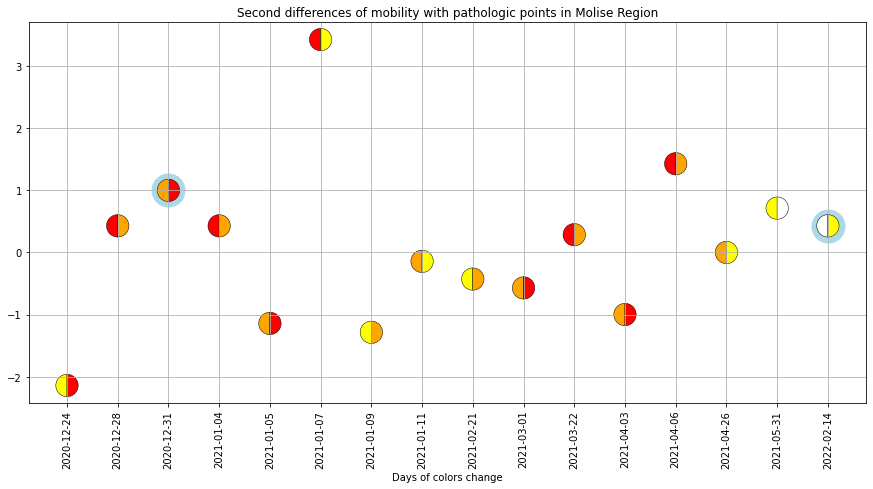

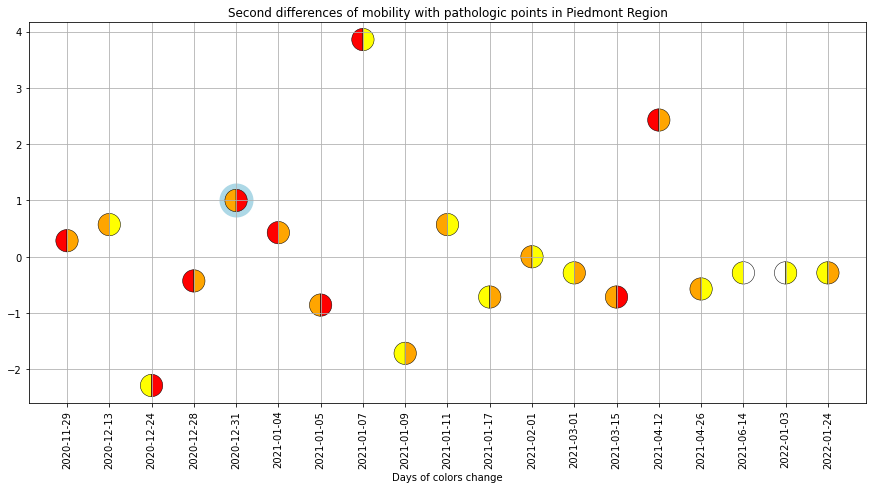

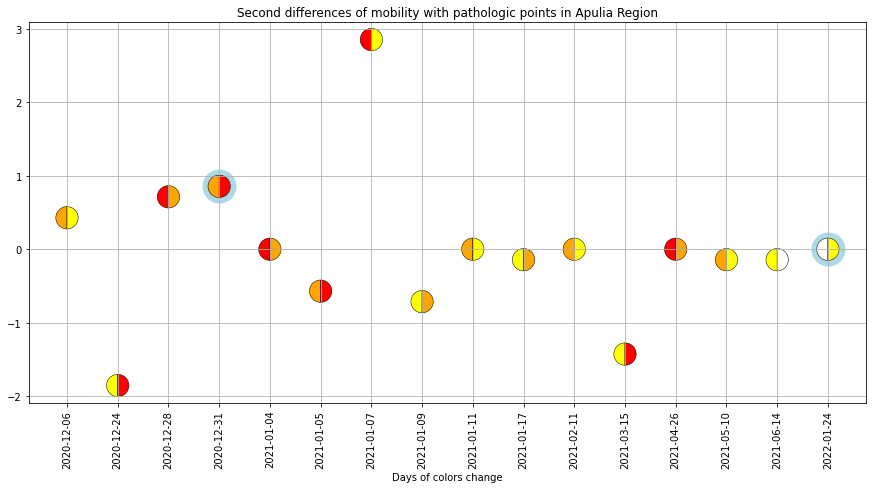

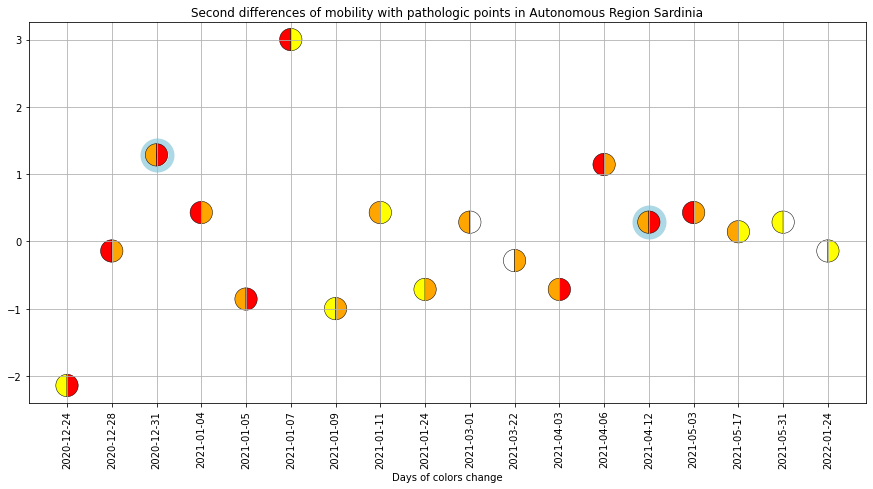

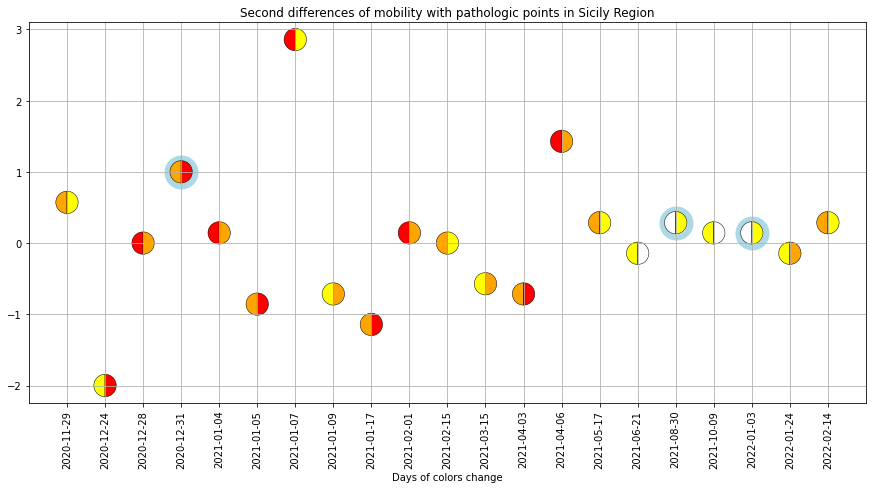

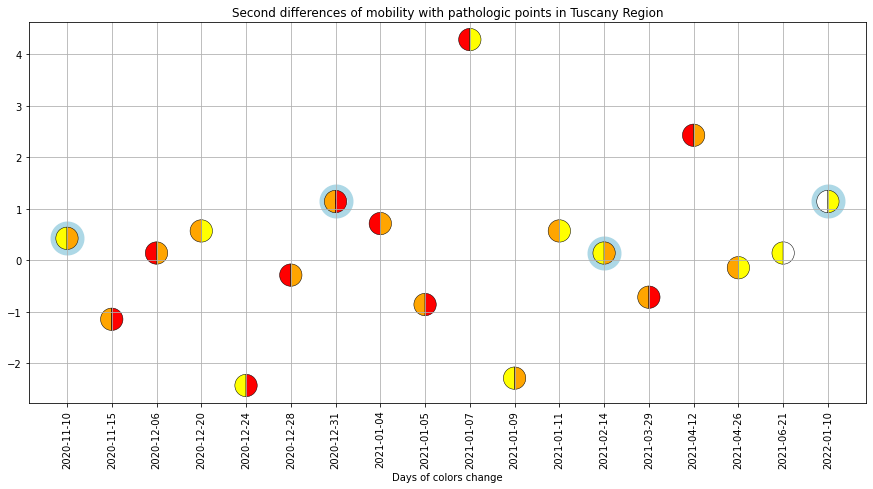

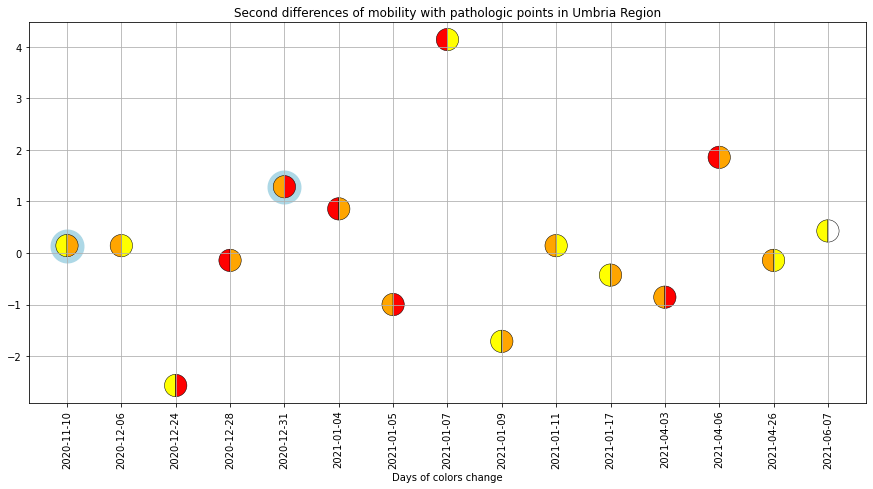

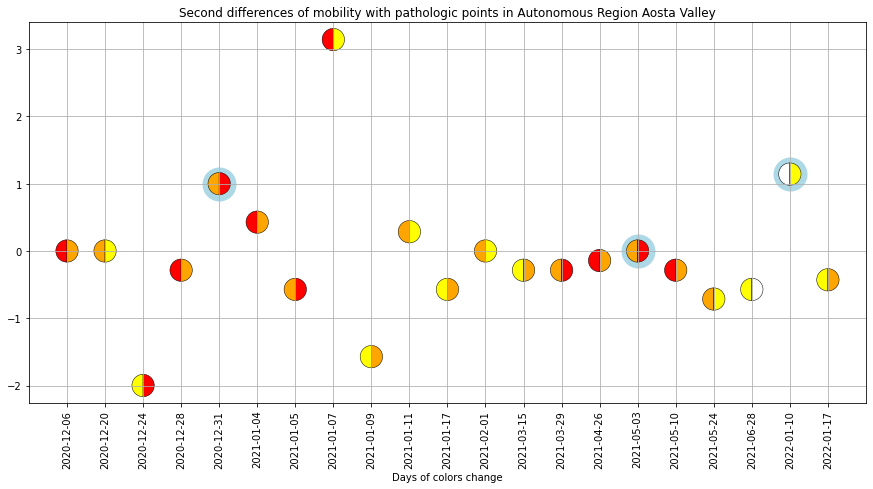

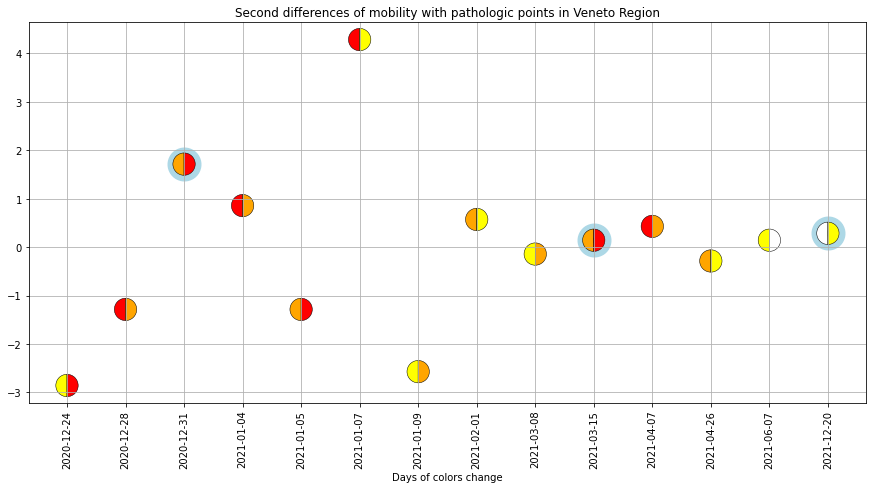

In [17]:
for region in actual_regions:

    df_mob = applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD[region]]}).iloc[:, 7]
    df_col = applyfilter(colors, {'denominazione_regione' : [region]})
    
    translate = {'bianco'    : 'white',
                'giallo'    : 'yellow',
                'arancione' : 'orange',
                'rosso'     : 'red'}

    color_list = [translate[col] for col in df_col.colore.values] # it's the time sequence without dates of colors
    start_date = df_col.iloc[0,0] # it's the start day of restrictions, the six of november the same for each region
    end_date   = df_col.iloc[-1,0] # the end of the dataframe is set to the 10th of february 2022
    slice_mob, mask_mob = from_to(dates_str_gmd, start_date, end_date) # slice mob is  just the slice in the time window that 
    # indicates the start and stop point of the time series. mask mob is the np.arange(slice_mob.start,slice_mob.stop) useful
    # for selecting those elements falling into the slice mob range 
    slice_col, mask_col = from_to(df_col.data.values, start_date, end_date)

    color_list = np.array(color_list[slice_col])
    old_colors_index = np.argwhere(~(np.array(color_list[1:]) == np.array(color_list[:-1]))).flatten()
    new_colors_index = old_colors_index + 1

    mobility_difference_list = (df_mob.iloc[mask_mob[1:]]).values - (df_mob.iloc[mask_mob[:-1]]).values
    second_derivative_mobility = mobility_difference_list[old_colors_index] - mobility_difference_list[old_colors_index-1]
    dates_color_change = np.array(dates_datetime_gmd[slice_mob])[new_colors_index]
    strenghten_restrictions = np.array([('white', 'yellow'), ('white', 'orange'), ('white', 'red'), ('yellow', 'orange'),
                                    ('yellow', 'red'), ('orange', 'red')])

    tmp = np.array([*zip(color_list[old_colors_index], color_list[new_colors_index])])
    combination_colors_mask = (tmp[:, None] == strenghten_restrictions).all(2).any(1) 
    positive_second_differences_and_color_combination = np.argwhere((second_derivative_mobility > 0) & combination_colors_mask).flatten()
    dates_no_sudden_restrictions = dates_color_change[positive_second_differences_and_color_combination]
    x1 = np.arange(len(second_derivative_mobility))
    plt.figure(figsize = (15,7))
    z, y = x1, second_derivative_mobility
    n = color_list[old_colors_index]
    plt.scatter(z[positive_second_differences_and_color_combination],second_derivative_mobility[positive_second_differences_and_color_combination],
                edgecolors='lightblue', linewidths=28)
    plt.scatter(z, y, color = color_list[old_colors_index], s = 500, edgecolors='black', linewidths=0.5, marker=MarkerStyle("o", fillstyle="left"))
    plt.scatter(z, y, color = color_list[new_colors_index], s = 500, edgecolors='black', linewidths=0.5, marker=MarkerStyle("o", fillstyle="right"))
    plt.xticks(z, dates_color_change, rotation = 'vertical')
    plt.title('Second differences of mobility with pathologic points in {}'.format(region_dict[region]))
    plt.xlabel('Days of colors change')
    plt.grid()
    plt.show()

Prima di tutto devo controllare se la i-esima iterazione sta ancora nella zona di cambio colore

Filtri per trovare il giorno in cui le restrizioni sono state applicate:

- il baricentro della retta a dx deve essere negativo e minore non di quello della retta a sinistra a lui adiacente perchè dai confronti in negativo non vale la proprietà transitiva ma deve essere minore della prima. Attenzione che comunque così facendo stiamo considerando il confronto soltanto tra zona con il nuovo colore "avanzata in giorni" e zona con vecchio colore. Al contrario se facessi un confronto a coppie andrei a vedere se i cittadini si sono accorti che si devono muovere meno ma dentro la nuova zona e non facendo riferimento a come si muovevano in quella prima.

Se passo questo filtro allora posso controllarne un altro;

- il coefficiente angolare della retta a destra deve essere più negativo di quella a sinistra. Questa volta però posso limitarmi a fare un confronto a coppie perchè mi interessa capire soltanto se il trend è quello di aumento della intensità di decremento di mobility. 

Se passo questo filtro ho trovato il giorno buono perchè:

1. In media i punti dentro la restrizione hanno un decremento di mobility più forte di quelli fuori se faccio il confrotnto con la prima retta altrimenti avranno un decremento più forte rispetto ai precedenti ma è probabile che sia per l'entrata in vigore della restrizione e non legato all'intensificarsi della restrizione stessa nel cambio colore da uno più chiaro a uno più scuro;
2. Oltre ad avere un decremento più forte in media anche la tendenza a decrescere nei giorni successivi è più forte di quella dei giorni nella regione fuori dalle restrizioni.

Se non passo nessuno di questi due controlli siginfica che la restrizione non ha avuto effetto per tutta la durata del nuovo colore

In [18]:
def com(points_list):
        return np.mean(points_list)

def slope(model):
        return model[0]

def first_filter(com_sx,com_dx):
        '''
        com_sx : the centre of mass of the first line 
        com_dx : the centre of mass of the second line
        this function returns whether the centre of mass of one line is lower than the centre of mass of a first one
        '''
        if com_dx < 0:
                return (com_dx < com_sx)
        else: return 'centre of mass is not negative'

def second_filter(slope_sx, slope_dx):
        '''
        this function returns whether the slope of a line is less than a first one's
        '''
        return slope_dx < slope_sx


In [19]:
zero_filter_list_regions = []
first_filter_list_regions = []
second_filter_list_regions = []
pathologic_days_list_regions = []
dates_color_change_regions = []
dates_color_change_patologic_regions = []
dates_color_change_patologic_scurimento = []
scurimento_regions = []

for region in actual_regions:
       
        df_mob = applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD[region]]}).iloc[:, 7]
        df_col = applyfilter(colors, {'denominazione_regione' : [region]})

        translate = {'bianco'    : 'white',
                    'giallo'    : 'yellow',
                    'arancione' : 'orange',
                    'rosso'     : 'red'}

        color_list = [translate[col] for col in df_col.colore.values] # it's the time sequence without dates of colors
        start_date = df_col.iloc[0,0] # it's the start day of restrictions, the six of november the same for each region
        end_date   = df_col.iloc[-1,0] # the end of the dataframe is set to the 10th of february 2022
        slice_mob, mask_mob = from_to(dates_str_gmd, start_date, end_date) # slice mob is  just the slice in the time window that 
        # indicates the start and stop point of the time series. mask mob is the np.arange(slice_mob.start,slice_mob.stop) useful
        # for selecting those elements falling into the slice mob range 
        slice_col, mask_col = from_to(df_col.data.values, start_date, end_date)

        color_list = np.array(color_list[slice_col])
        old_colors_index = np.argwhere(~(np.array(color_list[1:]) == np.array(color_list[:-1]))).flatten()
        new_colors_index = old_colors_index + 1

        mobility_difference_list = (df_mob.iloc[mask_mob[1:]]).values - (df_mob.iloc[mask_mob[:-1]]).values
        second_derivative_mobility = mobility_difference_list[old_colors_index] - mobility_difference_list[old_colors_index-1]
        dates_color_change = np.array(dates_datetime_gmd[slice_mob])[new_colors_index]
        strenghten_restrictions = np.array([('white', 'yellow'), ('white', 'orange'), ('white', 'red'), ('yellow', 'orange'),
                                        ('yellow', 'red'), ('orange', 'red')])

        tmp = np.array([*zip(color_list[old_colors_index], color_list[new_colors_index])])
        combination_colors_mask = (tmp[:, None] == strenghten_restrictions).all(2).any(1) 
        positive_second_differences_and_color_combination = np.argwhere((second_derivative_mobility > 0) & combination_colors_mask).flatten()
        dates_no_sudden_restrictions = dates_color_change[positive_second_differences_and_color_combination]
        dates_color_change_patologic = dates_color_change[positive_second_differences_and_color_combination] 
        dates_color_general = dates_datetime_gmd[slice_mob][1:] 
        dates_wrong_restrictions_indexes = np.argwhere(np.isin(dates_color_general,dates_color_change_patologic)).flatten()
        dates_scurimento = dates_color_change[combination_colors_mask]
        scurimento_ix = np.argwhere(combination_colors_mask == True).flatten()
        scurimento_ix_ix = np.argwhere(np.isin(dates_color_general, dates_scurimento)).flatten() # è lui quello buono per rinna
        window = 4
        x = np.arange(window)
        first_filter_list = []
        second_filter_list = []
        zero_filter_list = []
        n_of_patologic_days = dates_scurimento.shape[0]
        tmp = (np.argwhere(np.isin(dates_color_change,dates_scurimento)).flatten())

        dates_color_change_plus_end = np.append(dates_color_change, dates_datetime_gmd[slice_mob][1:][-1])
        n_of_days_in_color = [(dates_color_change_plus_end[1:] - dates_color_change_plus_end[:-1])[i].days for i in range(len(dates_color_change_plus_end[1:]))]

        for day in range(n_of_patologic_days):
              print('day', day+1, 'of', n_of_patologic_days, 'is considered')
              bar0 = com([mobility_difference_list[scurimento_ix_ix[day]-4],
                     mobility_difference_list[scurimento_ix_ix[day]-3],
                     mobility_difference_list[scurimento_ix_ix[day]-2],
                     mobility_difference_list[scurimento_ix_ix[day]-1]])
              i = 0
              # perchè sto usando i+2? perchè quando arrivo all'ultimo giorno dell'ultima zona l'indice i+2 di punti_dx e anche 
              # model_dx va out of bounds. Quindi mi devo fermare al terzultimo punto prima della fine della zona per restare 
              # dentro la stessa e nel frattempo non sforare nel caso dell'ultima zona della time series 
              while (i+3) <= n_of_days_in_color[tmp[day]]:
              # (tmp1 <= tmp[day + 1]): # c'è un errore, voglio fare la verifica sul numero di giorni quindi su i
              # questo deve diventare un while sull'ultima data che rientra nella zona colorata 
                     # punti_sx = [mobility_difference_list[scurimento_ix_ix[day]+i-4],
                     #        mobility_difference_list[scurimento_ix_ix[day]+i-3],
                     #        mobility_difference_list[scurimento_ix_ix[day]+i-2],
                     #        mobility_difference_list[scurimento_ix_ix[day]+i-1]]
                     punti_dx = [mobility_difference_list[scurimento_ix_ix[day]+i], 
                            mobility_difference_list[scurimento_ix_ix[day]+i+1],
                            mobility_difference_list[scurimento_ix_ix[day]+i+2],
                            mobility_difference_list[scurimento_ix_ix[day]+i+3]]
                     i+=1
                     # model_sx = np.polyfit(x,punti_sx,1)
                     model_dx = np.polyfit(x,punti_dx,1)
                     if np.all(np.array(punti_dx) < 0):
                            first_filter_list.append((day,i-1,first_filter(bar0,com(punti_dx))))
                            # i = 100
                            break

        pathologic_days_list_regions.append(n_of_patologic_days)
        # zero_filter_list_regions.append(zero_filter_list)
        first_filter_list_regions.append(first_filter_list)
        # second_filter_list_regions.append(second_filter_list)
        dates_color_change_regions.append(dates_color_change)
        dates_color_change_patologic_regions.append(dates_color_change_patologic)
        dates_color_change_patologic_scurimento.append(dates_scurimento)
        scurimento_regions.append(scurimento_ix)


day 1 of 11 is considered
day 2 of 11 is considered
day 3 of 11 is considered
day 4 of 11 is considered
day 5 of 11 is considered
day 6 of 11 is considered
day 7 of 11 is considered
day 8 of 11 is considered
day 9 of 11 is considered
day 10 of 11 is considered
day 11 of 11 is considered
day 1 of 7 is considered
day 2 of 7 is considered
day 3 of 7 is considered
day 4 of 7 is considered
day 5 of 7 is considered
day 6 of 7 is considered
day 7 of 7 is considered
day 1 of 7 is considered
day 2 of 7 is considered
day 3 of 7 is considered
day 4 of 7 is considered
day 5 of 7 is considered
day 6 of 7 is considered
day 7 of 7 is considered
day 1 of 8 is considered
day 2 of 8 is considered
day 3 of 8 is considered
day 4 of 8 is considered
day 5 of 8 is considered
day 6 of 8 is considered
day 7 of 8 is considered
day 8 of 8 is considered
day 1 of 8 is considered
day 2 of 8 is considered
day 3 of 8 is considered
day 4 of 8 is considered
day 5 of 8 is considered
day 6 of 8 is considered
day 7 of 8 i

In [20]:
lag_mobility_regions = []
for h in range(len(pathologic_days_list_regions)):
    # print(actual_regions[h])
    a = []
    # in questo modo se devo chiedere di restiruirmi la maschera per il primo giorno scrivo dic_days[1]
    
    # mask0 = [np.array(zero_filter_list_regions[h]).T[0] == i for i in range(pathologic_days_list_regions[h])]
    mask = [np.array(first_filter_list_regions[h]).T[0] == i for i in range(pathologic_days_list_regions[h])]
    # mask1 = [np.array(second_filter_list_regions[h]).T[0] == i for i in range(pathologic_days_list_regions[h])]

    a = []
    for j in range(pathologic_days_list_regions[h]): 
        # zero_filter_days = np.array(zero_filter_list_regions[h]).T[1][mask0[j]]
        first_filter_days = np.array(first_filter_list_regions[h]).T[1][mask[j]]
        # second_filter_days = np.array(second_filter_list_regions[h]).T[1][mask1[j]]
        pp = np.array(first_filter_list_regions[h]).T[2][mask[j]]
        
        # first_filter_days_nozero = first_filter_days[first_filter_days != 0]
        # second_filter_days_nozero = second_filter_days[second_filter_days != 0]
        try :
            ddd = int(first_filter_days)
            a.append([dates_color_change_patologic_scurimento[h][j],int(first_filter_days),int(pp)])
        except:
            a.append(([dates_color_change_patologic_scurimento[h][j],np.NaN,0]))
        
        # aa.append([actual_regions[h],a])

    lag_mobility_regions.append([actual_regions[h],a])

# questo è il numero di giorni utili per l'applicazione delle restrizioni 

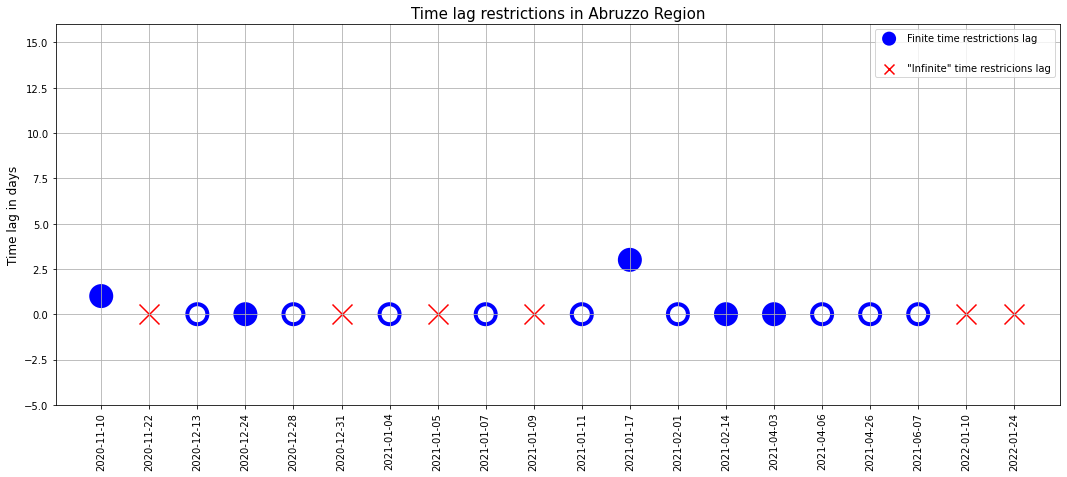

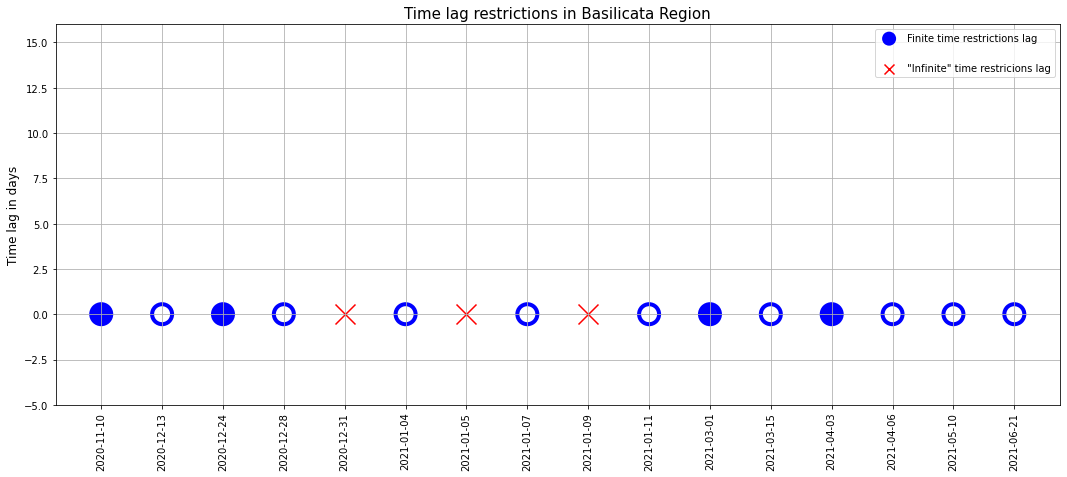

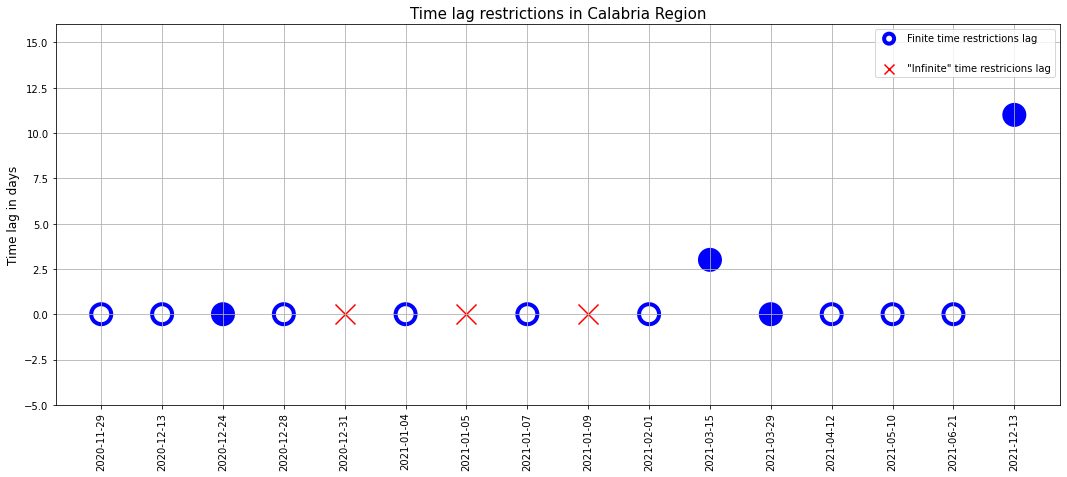

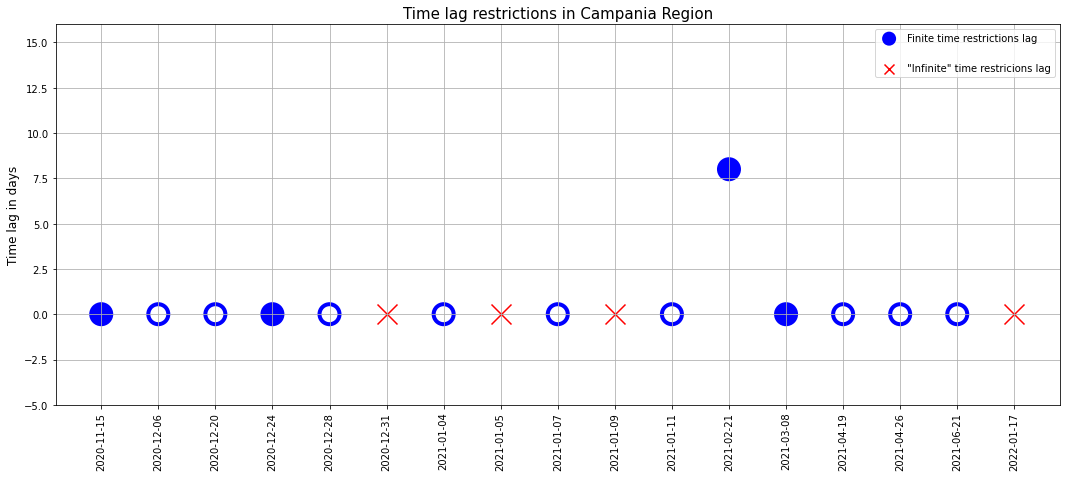

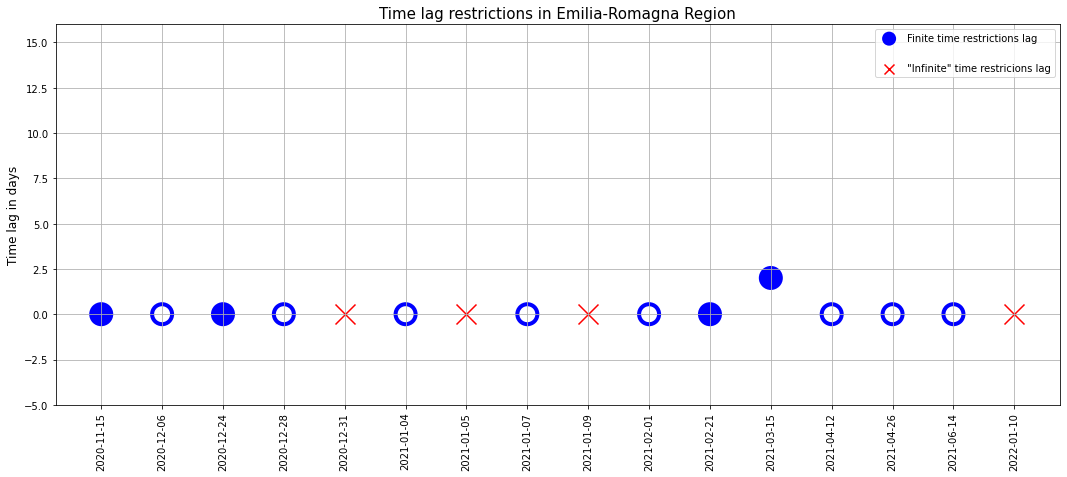

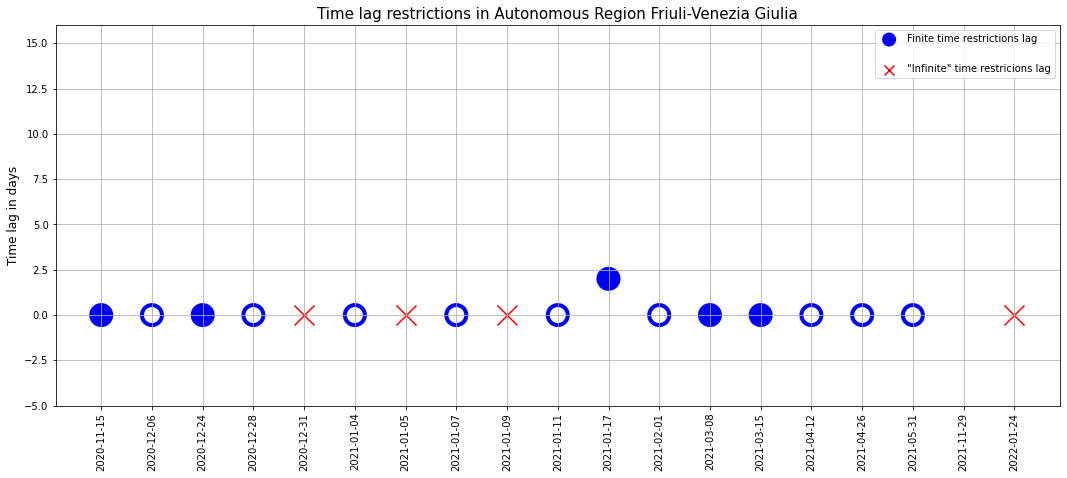

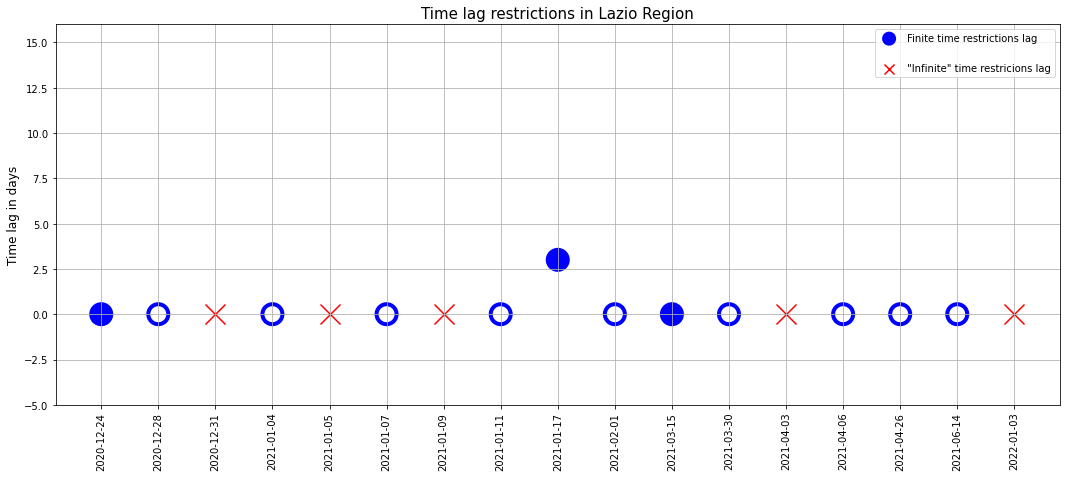

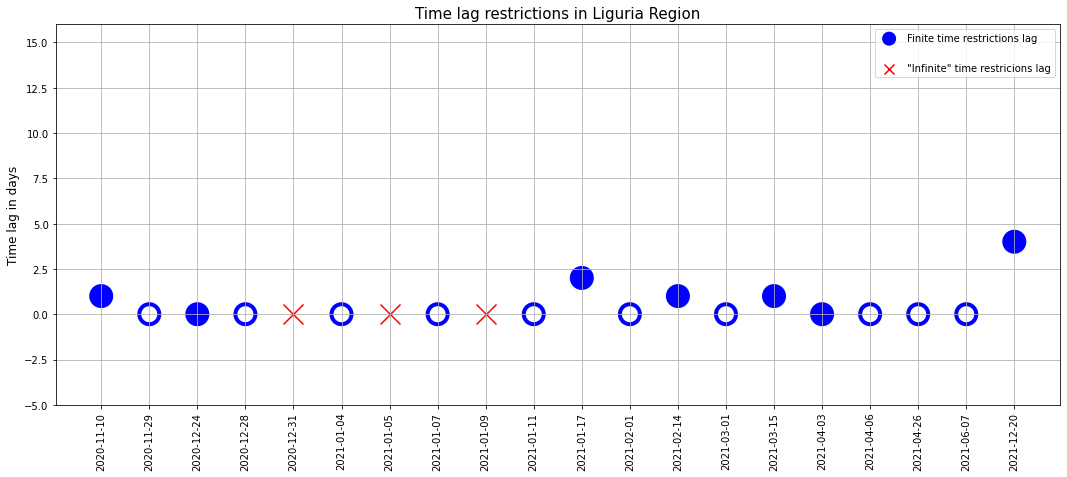

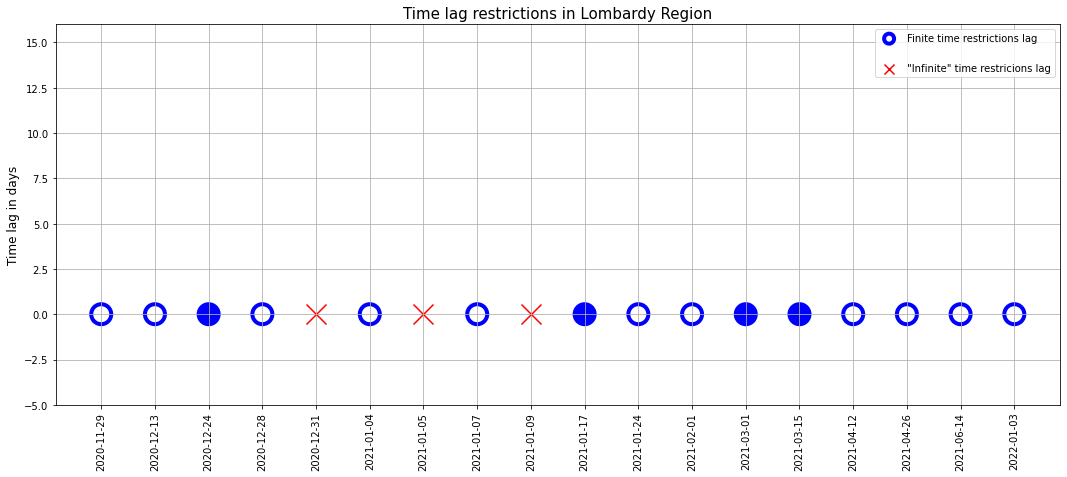

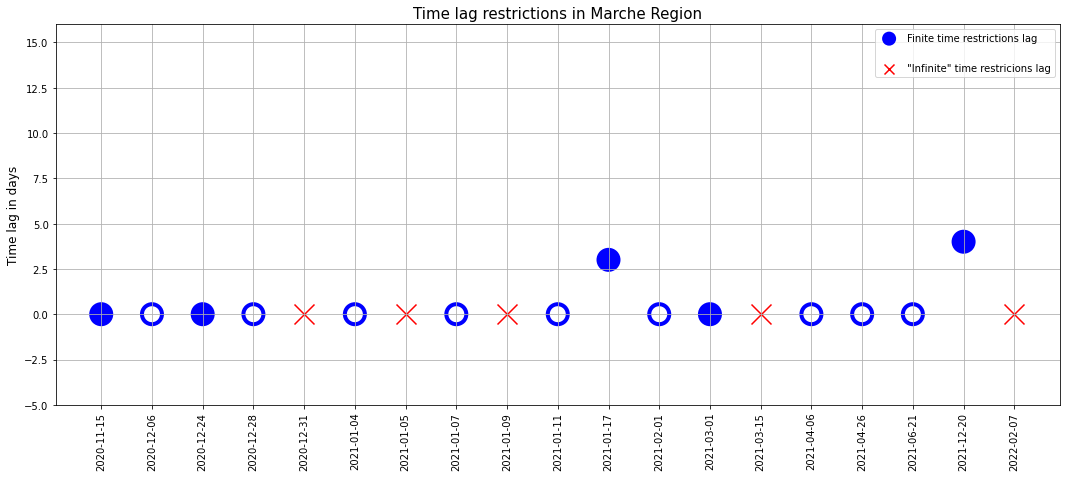

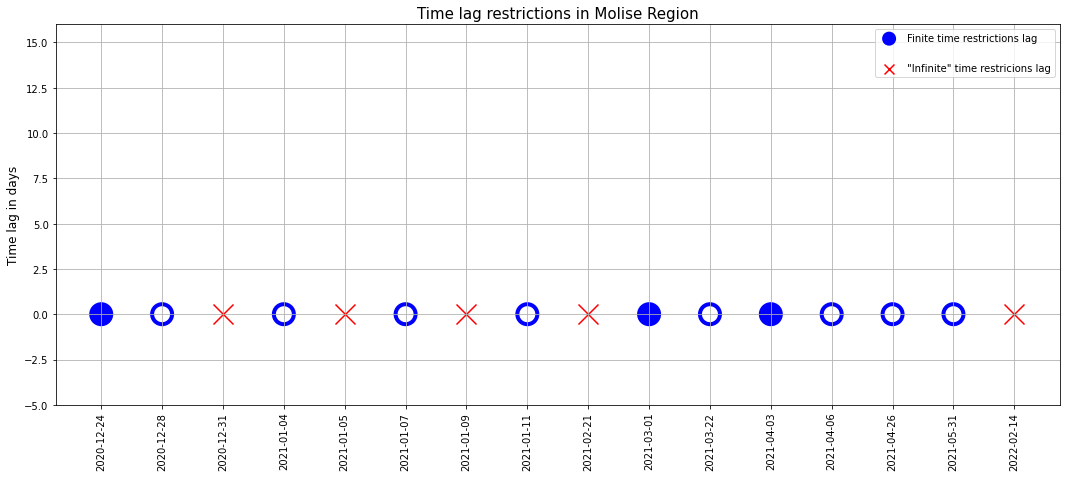

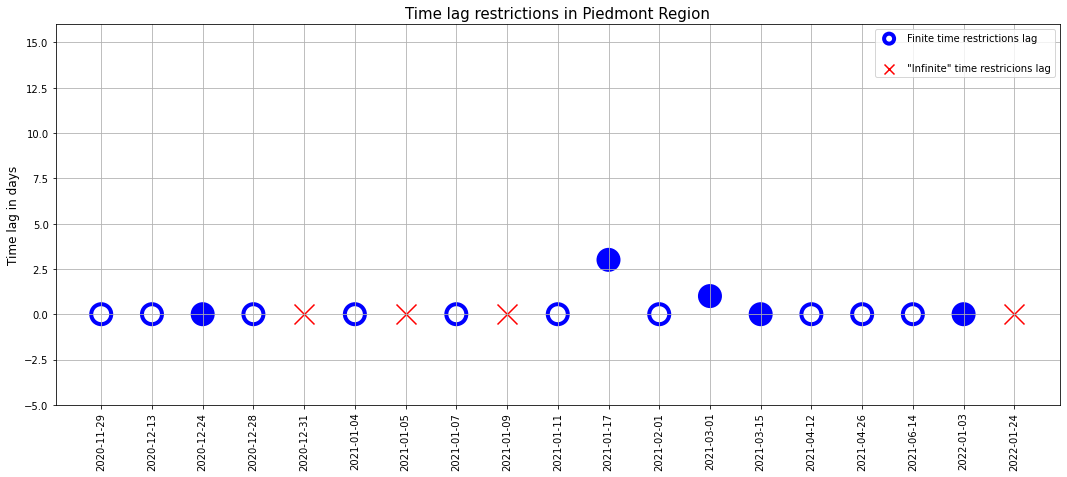

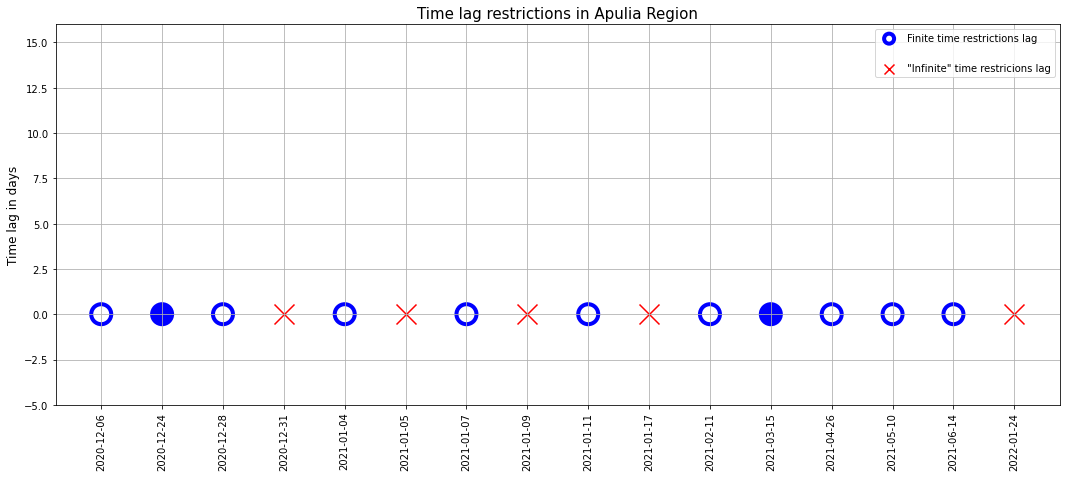

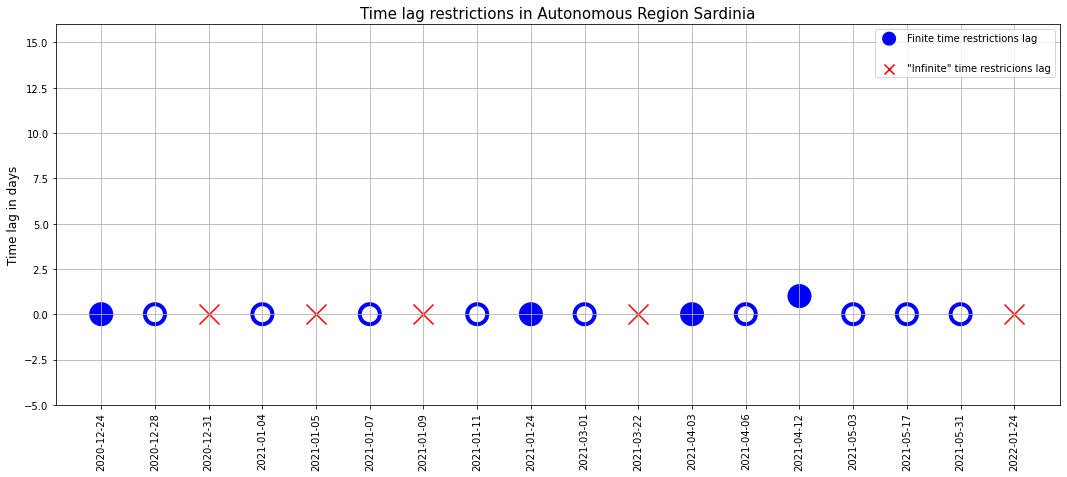

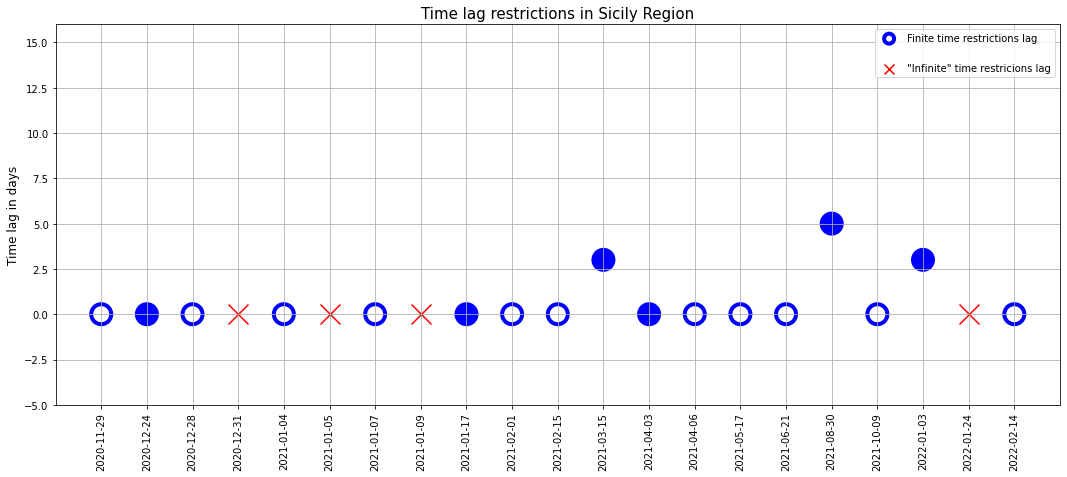

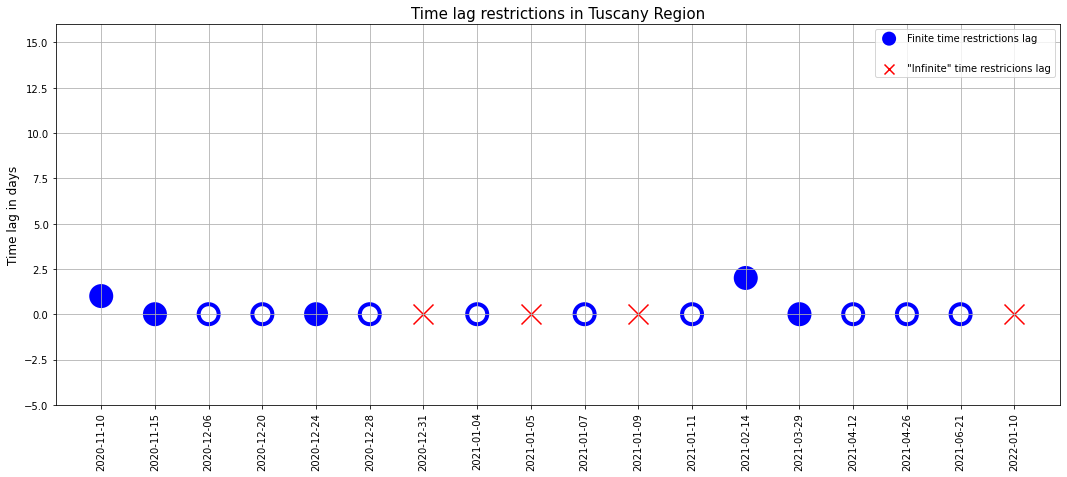

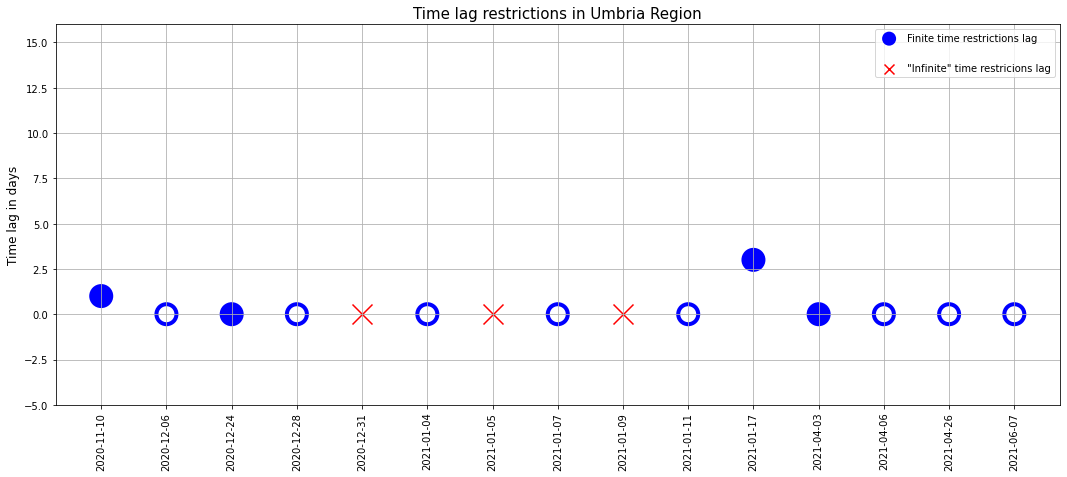

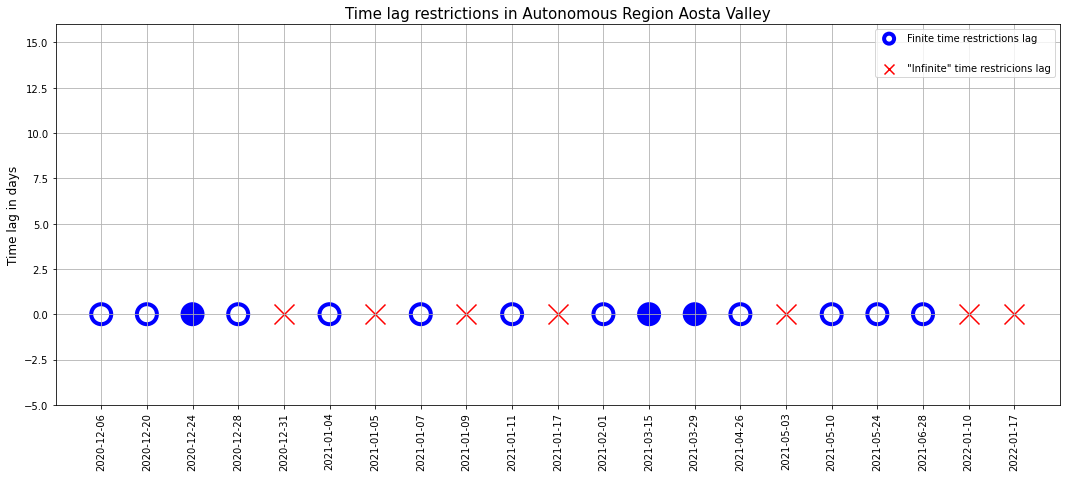

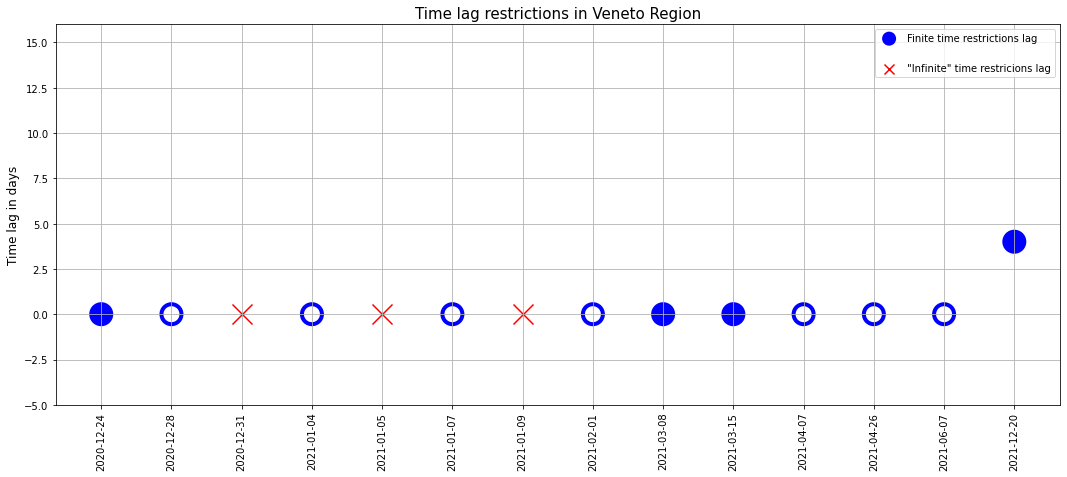

In [21]:
lag_and_data = dict()
bool_color = ('none','b')
for j,k in enumerate(actual_regions):
    
    cacca = np.zeros(len(dates_color_change_regions[j]))
    cacca[scurimento_regions[j]] = (np.array(lag_mobility_regions[j][1]).T)[2]
    face = [bool_color[val] for val in cacca.astype(int)]

    b = np.array([(dates_color_change_regions[j][i],0) for i in range(len(dates_color_change_regions[j]))])
    b[(np.isin(dates_color_change_regions[j], np.array(lag_mobility_regions[j][1]).T[0]))] = np.array(lag_mobility_regions[j][1])[:,:-1]
    nan_indexes = np.argwhere(b.T[1] != b.T[1]).flatten()
    plt.figure(figsize=(18,7))
    plt.scatter(np.arange(len(dates_color_change_regions[j])),b.T[1], marker='o', s=400, color = 'b', 
                label = 'Finite time restrictions lag', linewidth = 4, facecolors = face)
    plt.scatter(nan_indexes, np.zeros(len(dates_color_change_regions[j][nan_indexes])), 
                marker='x', color = 'r', s=400, label = '"Infinite" time restricions lag')
    plt.xticks(np.arange(len(dates_color_change_regions[j])),dates_color_change_regions[j], rotation='90')
    plt.grid()
    lgnd = plt.legend(labelspacing = 2, numpoints = 1, fontsize = 10)
    lgnd.legendHandles[0]._sizes = [100]
    lgnd.legendHandles[1]._sizes = [100]
    plt.ylabel('Time lag in days', fontsize = 12)
    plt.title('Time lag restrictions in {}'.format(region_dict[k]), fontsize = 15)
    plt.ylim(-5,16)
    plt.show()
    lag_and_data[k] = [b.T[1], dates_color_change_regions[j]]

In [22]:
unique_dates = []
for region in actual_regions:
    tmp = generate_tseries(applyfilter(colors, {'denominazione_regione' : [region]}))
    for color in tmp.keys():
        for pair in tmp[color]:
            # print(pair)
            unique_dates.append(pair[0])
unique_dates = list(np.unique(unique_dates))
unique_dates = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in unique_dates]

<ipython-input-23-17ef800f1276>:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



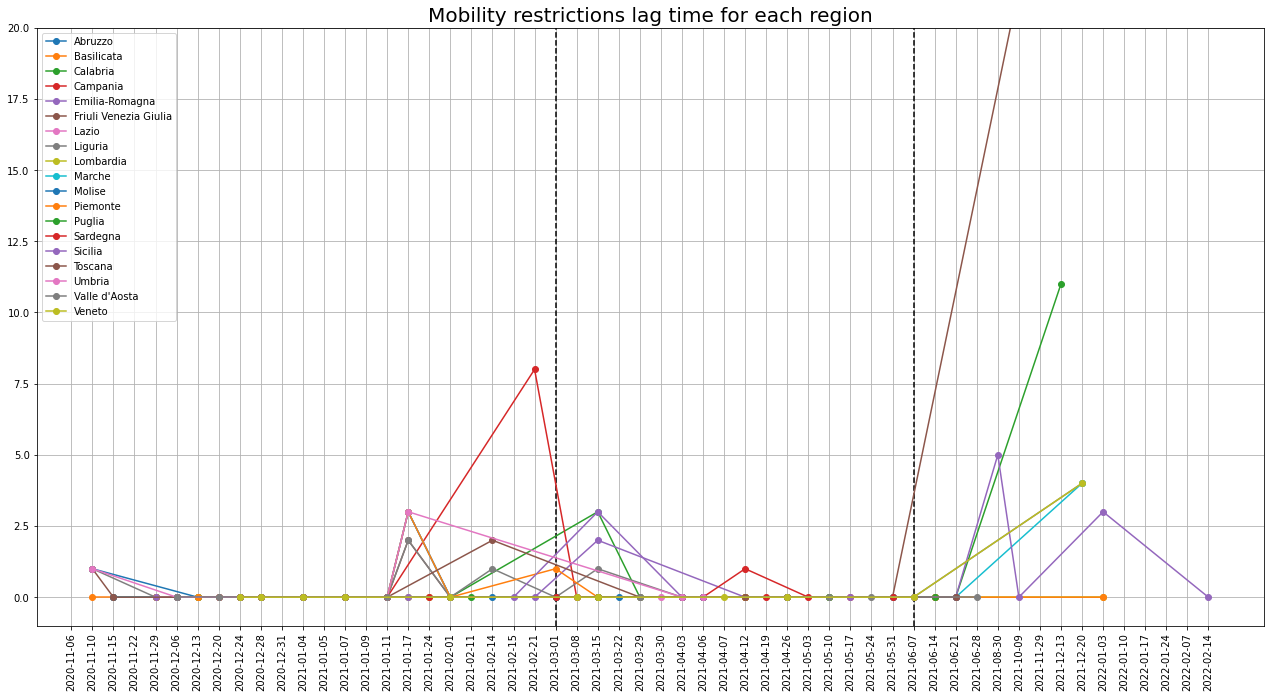

In [23]:
from matplotlib.cm import get_cmap
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb
from cycler import cycler


first_window = np.array(unique_dates)[np.array([(date.month == 3) & (date.year == 2021) for date in unique_dates]).flatten()][0]
first_window = np.argwhere(np.isin(unique_dates, first_window)).flatten()

second_window = np.array(unique_dates)[np.array([(date.month == 6) & (date.year == 2021) for date in unique_dates]).flatten()][0]
second_window = np.argwhere(np.isin(unique_dates, second_window)).flatten()

third_window = np.array(unique_dates)[np.array([(date.month == 2) & (date.year == 2022) for date in unique_dates]).flatten()][0]
third_window = np.argwhere(np.isin(unique_dates, third_window)).flatten()


all_ix = []
plt.figure(figsize = (22,11))
for region in actual_regions:
    ix = []
    for date in lag_and_data[region][1]:
        ix.append(unique_dates.index(date))
    # print(ix)
    # break
    nan_ix_tmp = (lag_and_data[region][0] == lag_and_data[region][0])
    all_ix.append(ix)
    # nan_ix_tmp = np.argwhere(lag_and_data[region][0] != lag_and_data[region][0]).flatten()

    plt.plot(np.array(ix)[nan_ix_tmp], (lag_and_data[region][0])[nan_ix_tmp], '-o', label = region)

all_ix = np.unique(np.array(all_ix).flatten())
plt.xticks(np.arange(len(unique_dates)), unique_dates, rotation = '90')
plt.ylim(-1,20)
plt.title('Mobility restrictions lag time for each region', fontsize = 20)
plt.vlines(first_window, -1,20, linestyles='dashed', color='k')
plt.vlines(second_window, -1,20, linestyles='dashed', color='k')
# plt.vlines(third_window, -1,20, linestyles='dashed', color='k')

plt.grid()
plt.legend(loc = 'upper left')

name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colorss = cmap.colors  # type: list
plt.rc('axes', prop_cycle=(cycler('color', colorss)))
plt.show()

<ipython-input-24-e781210f38be>:14: RuntimeWarning:

invalid value encountered in less

<ipython-input-24-e781210f38be>:14: RuntimeWarning:

invalid value encountered in less

<ipython-input-24-e781210f38be>:14: RuntimeWarning:

invalid value encountered in less

<ipython-input-24-e781210f38be>:14: RuntimeWarning:

invalid value encountered in less

<ipython-input-24-e781210f38be>:14: RuntimeWarning:

invalid value encountered in less

<ipython-input-24-e781210f38be>:14: RuntimeWarning:

invalid value encountered in less

<ipython-input-24-e781210f38be>:14: RuntimeWarning:

invalid value encountered in less

<ipython-input-24-e781210f38be>:14: RuntimeWarning:

invalid value encountered in less

<ipython-input-24-e781210f38be>:14: RuntimeWarning:

invalid value encountered in less

<ipython-input-24-e781210f38be>:14: RuntimeWarning:

invalid value encountered in less

<ipython-input-24-e781210f38be>:14: RuntimeWarning:

invalid value encountered in less

<ipython-input-24-e781210f38be>:

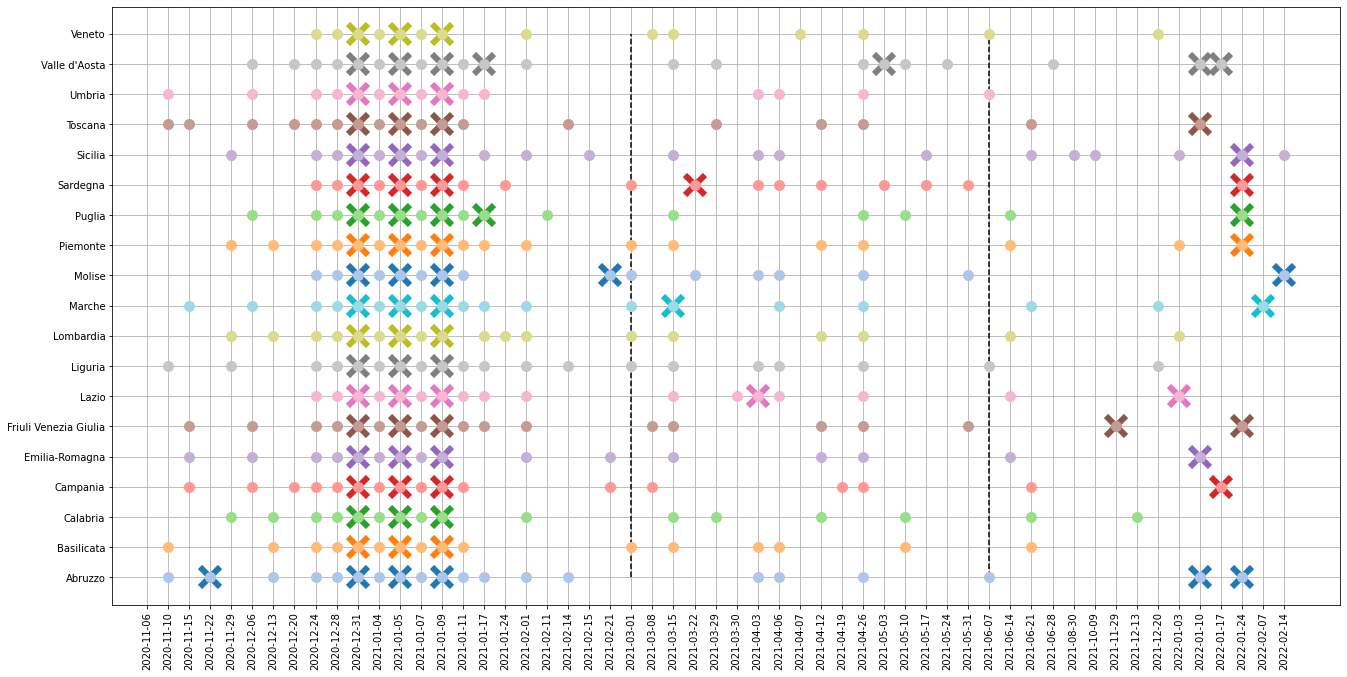

In [24]:
regions_num = {}
for i,j in enumerate(actual_regions):
    regions_num[j] = i+1

all_ix = []
plt.figure(figsize = (22,11))
for region in actual_regions:
    ix = []
    for date in lag_and_data[region][1]:
        ix.append(unique_dates.index(date))
    # print(ix)
    # break
    nan_ix_tmp = (lag_and_data[region][0] == lag_and_data[region][0])
    wrong_ix = np.argwhere((lag_and_data[region][0] < 14) == False).flatten()
    all_ix.append(ix)
    # nan_ix_tmp = np.argwhere(lag_and_data[region][0] != lag_and_data[region][0]).flatten()
    
    plt.plot(np.array(ix)[wrong_ix], np.zeros(len(np.array(ix)[wrong_ix])) + regions_num[region], 'x', 
             markersize=20, markeredgewidth=6)
    plt.plot(np.array(ix), np.zeros(len(ix)) + regions_num[region], 'o', markersize=10)

    # plt.yticks(np.zeros(len(ix)) + regions_num[region], region)

plt.vlines(first_window, 1,len(actual_regions), linestyles='dashed', color='k')
plt.vlines(second_window, 1,len(actual_regions), linestyles='dashed', color='k')
all_ix = np.unique(np.array(all_ix).flatten())
plt.xticks(np.arange(len(unique_dates)), unique_dates, rotation = '90')
plt.yticks(np.arange(len(actual_regions))+1, actual_regions)
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colorss = cmap.colors  # type: list
plt.rc('axes', prop_cycle=(cycler('color', colorss)))
plt.grid()
plt.show()